In [197]:
%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems

import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

In [198]:
import scanpy.api as sc
import pandas as pd
adata = sc.read_10x_mtx('/home/mt/Downloads/E40_motor_Out/outs/raw_gene_bc_matrices/refdata-celranger-mmul8-toplevel/',cache=True)
bcs=list(pd.read_csv('/home/mt/Downloads/E40_motor_Out/outs/filtered_gene_bc_matrices/refdata-celranger-mmul8-toplevel/barcodes.tsv').iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=50,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
adata=adata[adata.obs.n_counts.argsort(),:]


In [199]:
adata._inplace_subset_obs(np.random.choice(adata.obs.index,17000,replace=False))
adata._inplace_subset_var(np.random.choice(adata.var.index,4000,replace=False))
sc.pp.filter_genes(adata, min_cells=50,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
adata

AnnData object with n_obs × n_vars = 11110 × 2180 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

In [200]:
from scipy.stats import gaussian_kde
ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].obs.n_counts)

def from_epdf(param, ambient_counts):
    smin, smax = np.min(ambient_counts), np.max(ambient_counts)
    width = smax - smin
    x = np.linspace(smin, smax, 200)
    y = gaussian_kde(ambient_counts)(x)
    x = np.concatenate([[-1e9,-100,0], x, [x[-1] + np.log10(10)]])
    y = np.concatenate([[1e-1000,1e-200,1e-2], y, [1e-20]])
    #print(x)
    #print(y)
    sns.scatterplot(x,y)
    plt.show()
    return Interpolated(param, x, y)

In [201]:
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]



In [202]:
feature_names=list(adata.var.index)
tf=adata.X.copy()


In [203]:
n_samples_tr = tf.shape[0]
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 11110
Number of docs for test = 0
Number of tokens in training set = 1037915.0
Sparsity = 0.021361448071412645


In [204]:
n_topics=10
L = (1.0 / n_topics) * np.ones((tf.shape[0], n_topics))
L[junk_inds,:]=1e-50
L[junk_inds,L.shape[1]-1]=1
L=pm.floatX(L)

In [205]:
L

array([[1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00],
       [1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00],
       [1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00],
       ...,
       [1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00],
       [1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00],
       [1.e-50, 1.e-50, 1.e-50, ..., 1.e-50, 1.e-50, 1.e+00]])

In [206]:
def logp_lda_doc(doc_t,beta, theta,L,density):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    dixs : which doc
    vixs : which word
    vfreqs : frequency of doc x word
    """
    def ll_docs_f(inds):
        #print(docs.eval())
        inds=inds.eval()
        docs=shared(doc_t[inds,:].toarray())
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        inds=inds.astype('int32')
        subtheta=theta[inds,:]
        '''tt.printing.Print('dixs')(dixs)
        tt.printing.Print('docT')(inds.astype('int32'))
        tt.printing.Print('LFull')(tt.log10(L))
        tt.printing.Print('L')(tt.log10(L[inds,:][dixs]))
        tt.printing.Print('Lsummax')(tt.max(tt.sum(tt.log10(L[dixs]),axis=1)))
        tt.printing.Print('Lsubsummax')(tt.max(tt.sum(tt.log10(L[inds,:][dixs]),axis=1)))
        tt.printing.Print('thetafull')(theta.shape)
        tt.printing.Print('theta')(tt.log10(theta[dixs]))
        tt.printing.Print('beta')(tt.log10(beta.T[vixs]))'''
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log10(L[inds,:][dixs]) + tt.log10(subtheta[dixs]) + tt.log10(beta.T[vixs]),
            #tt.log10(theta[inds,:][dixs]) + tt.log10(beta.T[vixs]),
            axis=1).ravel()
        #*(tt.sum(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*theta[0:,theta.shape[1]-1]))) / beta.shape[1])
        # Per-word log-likelihood times num of tokens in the whole dataset * Log likelihood of 
        #tt.printing.Print('prob')(ambient.distribution.logp(2))
        #tt.printing.Print('docs')(docs)
        tt.printing.Print('logsum')(tt.log10(tt.sum(docs,axis=1)))
        #tt.printing.Print('subtheta')(subtheta)
        tt.printing.Print('logsum+theta')(tt.sum(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*subtheta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1]))
        tt.printing.Print('distout')((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens))
        tt.printing.Print('likelihood')((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*subtheta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1])))
        #tt.printing.Print('lldocs')(ll_docs)
        return ((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10((tt.sum(docs,axis=1)+1e-9)*subtheta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1])))

    return ll_docs_f


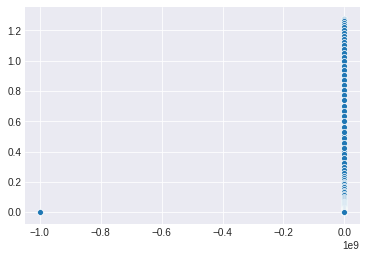

logsum __str__ = [1.0791812 0.69897   1.6532125 1.30103   1.968483  1.9637878 1.4771212
 1.6334685 1.3802112 1.7708521 3.8155112 1.3424227 1.462398  2.075547
 1.90309   1.3802112 1.5185139 1.5440681 0.90309   1.39794   1.4471581
 1.3222193 1.230449  1.462398  0.69897   1.5314789 1.30103   1.7075702
 0.90309   0.845098  1.6434526 1.3222193 1.90309   1.230449  1.3617278
 1.30103   0.845098  2.071882  1.5563025 0.69897   1.5682018 0.9542425
 1.5910646 0.90309   1.39794   0.69897   1.5910646 1.2552725]
logsum+theta __str__ = -48.21824278383789
distout __str__ = -3211750.6258665863
likelihood __str__ = -3211798.8441093704
logsum __str__ = [1.0791812 0.69897   1.6532125 1.30103   1.968483  1.9637878 1.4771212
 1.6334685 1.3802112 1.7708521 3.8155112 1.3424227 1.462398  2.075547
 1.90309   1.3802112 1.5185139 1.5440681 0.90309   1.39794   1.4471581
 1.3222193 1.230449  1.462398  0.69897   1.5314789 1.30103   1.7075702
 0.90309   0.845098  1.6434526 1.3222193 1.90309   1.230449  1.3617278
 1.3

In [225]:
n_topics = 10
# we have sparse dataset. It's better to have dense batch so that all words occur there
minibatch_size = 48
n_words=tf.shape[1]

# defining minibatch
#Can't load these arrays
doc_t_minibatch = pm.Minibatch(list(range(docs_tr.shape[0])), minibatch_size)
doc_t = np.random.choice(list(range(docs_tr.shape[0]-1)),minibatch_size-2)
#print(list(doc_t)+[0])
doc_t=[0,docs_tr.shape[0]-1]+list(doc_t)
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX(L),
                      shape=(docs_tr.shape[0], n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=docs_tr.shape[0])
    beta = Dirichlet('beta', a=pm.floatX((10.0 / n_topics) * np.ones((n_topics, n_words))),
                     shape=(n_topics, n_words), transform=t_stick_breaking(1e-9))
    ambient=from_epdf('ambient',ambient_counts)
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    doc = pm.DensityDist('doc', logp_lda_doc(docs_tr,beta, theta,shared(L),ambient), observed=doc_t)

In [226]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.tanh(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [227]:
encoder = LDAEncoder(n_words=n_words, n_hidden=100, n_topics=n_topics, p_corruption=0.0)
print('Built Encoder')
local_RVs = OrderedDict([(theta, encoder.encode(shared(docs_tr[doc_t,:].toarray())))])
doc_t=shared(doc_t)
local_RVs

Built Encoder


OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [228]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

In [229]:
#https://alexioannides.com/2018/11/07/bayesian-regression-in-pymc3-using-mcmc-variational-inference/
η = .5
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.5)

with model:
    #step = pm.Metropolis()
    #start = pm.find_MAP(model=model,progressbar=True)
    #step = pm.NUTS()
    #trace=pm.sample(draws=1000, progressbar=True)
    #approx = pm.fit(100, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    advi_fit=pm.fit(method=pm.ADVI(),callbacks=[reduce_rate], n=1000000,more_replacements={doc_t: doc_t_minibatch})


  0%|          | 0/1000000 [00:00<?, ?it/s]/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 1.9916e+07:   9%|▉         | 93276/1000000 [17:21:03<11:03:48, 22.77it/s]      
Interrupted at 93,278 [9%]: Average Loss = 2.1433e+07


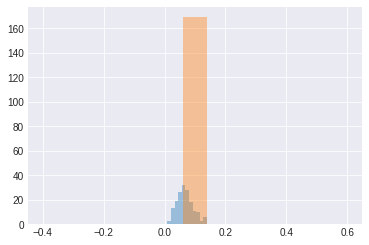

In [224]:
sns.distplot(np.mean(advi_fit.sample(50)['theta'],axis=0)[cell_inds,8],kde=False)
sns.distplot(model.theta.__getstate__()['tag'].__dict__['test_value'][cell_inds,9],kde=False)

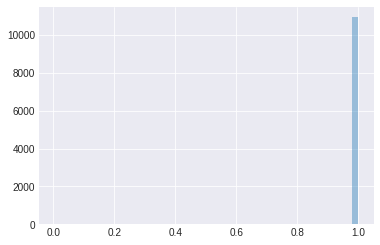

In [214]:
sns.distplot(np.mean(advi_fit.sample(20)['theta'],axis=0)[:,9],kde=False)


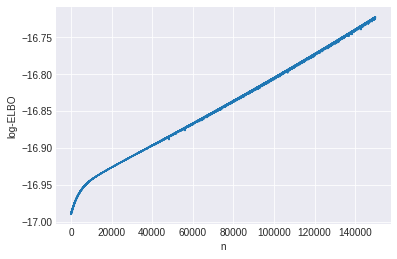

In [215]:
advi_elbo = pd.DataFrame(
    {'log-ELBO': -np.log(advi_fit.hist),
     'n': np.arange(advi_fit.hist.shape[0])})

sns.lineplot(y='log-ELBO', x='n', data=advi_elbo)

In [216]:
import pickle 
with open('/home/mt/Desktop/advimodel.pickle', 'wb') as buff:
    pickle.dump({ 'theta': np.mean(advi_fit.sample(50)['theta'],axis=0)}, buff)

with open('/home/mt/Desktop/advimodel.pickle', 'rb') as buff:
    data = pickle.load(buff)
theta = data['theta']

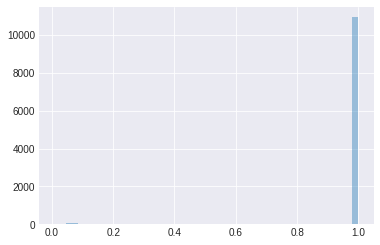

In [217]:
sns.distplot(theta[:,9],kde=False)

MissingInputError: Input 0 of the graph (indices start from 0), used to compute InplaceDimShuffle{1,0}(beta_stickbreaking__), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])


In [ ]:
η = .15
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)
    
with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(400,callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t: doc_t_minibatch})

In [120]:
dir(model.theta)

for f in dir(model.theta):
    try:
        print(f)
        print(getattr(model.theta, f)())
    except:
        print('fail',f)

T
fail T
__abs__
Elemwise{abs_,no_inplace}.0
__add__
fail __add__
__and__
fail __and__
__array_priority__
fail __array_priority__
__bool__
True
__class__
fail __class__
__count__
fail __count__
__delattr__
fail __delattr__
__dict__
fail __dict__
__dir__
['tag', 'type', 'owner', 'index', 'name', 'auto_name', 'transformation', 'model', 'distribution', 'dshape', 'dsize', 'transformed', 'scaling', 'random', '__module__', '__doc__', '__init__', '_repr_latex_', '__latex__', 'init_value', '__abs__', '__neg__', '_is_nonzero', '__lt__', '__le__', '__gt__', '__ge__', '__nonzero__', '__bool__', '__invert__', '__and__', '__or__', '__xor__', '__rand__', '__ror__', '__rxor__', '__add__', '__sub__', '__mul__', '__div__', '__truediv__', '__pow__', '__mod__', '__divmod__', '__floordiv__', '__rtruediv__', '__rfloordiv__', '__radd__', '__rsub__', '__rmul__', '__rdiv__', '__rmod__', '__rdivmod__', '__rpow__', 'T', 'transpose', 'shape', 'size', 'any', 'all', 'reshape', 'dimshuffle', 'flatten', 'ravel', 'di

Elemwise{sinh,no_inplace}.0
size
fail size
sort
SortOp{quicksort, None}.0
sqrt
Elemwise{sqrt,no_inplace}.0
squeeze
InplaceDimShuffle{0,1}.0
std
std
sum
Sum{acc_dtype=float64}.0
swapaxes
fail swapaxes
tag
fail tag
take
fail take
tan
Elemwise{tan,no_inplace}.0
tanh
Elemwise{tanh,no_inplace}.0
trace
Sum{acc_dtype=float64}.0
transfer
fail transfer
transformation
fail transformation
transformed
fail transformed
transpose
theta.T
trunc
Elemwise{trunc,no_inplace}.0
type
<TensorType(float64, matrix)>
var
var
zeros_like
Elemwise{second,no_inplace}.0


TypeError: string indices must be integers

In [102]:
advi_fit.

NameError: name 'd' is not defined

In [ ]:
model.theta.random()

In [ ]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

print_top_words(beta_pymc3, feature_names)

In [ ]:
sns.distplot(samples['theta'].mean(axis=0)[:,9],kde=False,bins=20)

In [ ]:
samples['theta'].mean(axis=0).shape

In [ ]:
encoder.get_params()